# Time Series Forecasting of JPMorgan Chase stock data.
### Name: Shravan Kuchkula

## Abstract
Time series is different from more traditional classification and regression predictive modeling problems. The temporal structure adds an order to the observations. This imposed order means that important assumptions about the consistency of those observations needs to be handled specifically. For example, when modeling, there are assumptions that the summary statistics of observations are consistent. In time series terminology, this expectation is referred to as the time series being stationary. These assumptions can be easily violated in time series by the addition of a trend, seasonality, and other time-dependent structures. Statistical modeling methods assume or require the time series to be stationary to be effective. One such model is the Autoregressive Integrated Moving Average Model, or ARIMA for short, is a standard statistical model for time series forecast and analysis.

## Introduction
Forecasting the closing price of a stock each day is one use case where time series data is commonly used. The data used here is `JPMorgan Chase's` closing price from January 2014 to May 2018. The Investors Exchange (IEX) provides a wide range of data through an API. Historical stock prices are available for up to 5 years. `pandas_datareader` module is used to get the data. Goal is to check if the time series is stationary and move on to using a ARIMA model. The parameters for ARIMA are first manually entered by inspecting the two widely used diagonostic plots - ACF and PACF plots. Next, a grid search technique is used to determine the best p, q and d values that yield the least Root Mean Squared Error. 

5y


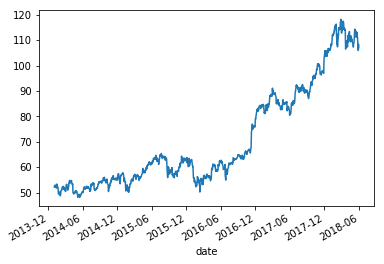

In [20]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline

from pandas_datareader import data as web
import datetime
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 5, 31)
price = web.DataReader('JPM', 'iex', start, end)['close']
price.index = pd.to_datetime(price.index)
price.plot()

Visually inspecting the above plot, reveals that there could be a trend component in this time series. 

### Stationary test
A stationary time series is one where the values are not a function of time. Time series are stationary if they do not have trend or seasonal effects. Statistical tests like `Augmented Dicky-Fuller unit root test` can be used to check if a given time series is stationary or not. 

The Statsmodels library provides tools for statistical modeling. It provides a suite of statistical test and modeling methods, as well as tools dedicated to time series analysis that can also be used for forecasting. Key features of Statsmodels relevant to time series forecasting include:

 - Statistical tests for stationarity such as the `Augmented Dickey-Fuller unit root test`.
 - Time series analysis plots such as `autocorrelation function (ACF)` and `partial autocorrelation function (PACF)`.
 - Linear time series models such as `autoregression (AR)`, `moving average (MA)`, `autoregressive moving average (ARMA)`, and `autoregressive integrated moving average (ARIMA)`.

Reference: http://www.statsmodels.org/stable/tsa.html

The `test_stationarity()` function displays the results of Dickey-Fuller test along with the rolling mean and standard deviation. 

In [21]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(round(dfoutput, 3))

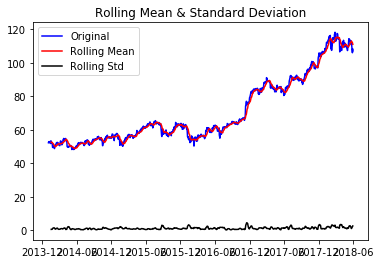

Results of Dickey-Fuller Test:
Test Statistic                    0.223
p-value                           0.974
#Lags Used                        5.000
Number of Observations Used    1105.000
Critical Value (1%)              -3.436
Critical Value (5%)              -2.864
Critical Value (10%)             -2.568
dtype: float64


In [22]:
test_stationarity(price)

**Null Hypothesis (H0)**: If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

The test-statistic of 0.223 and a p-value of 0.974 suggests that this is a **non-stationary time series**. 

### Differencing
Differening is a term used to refer to taking the difference between the current and previous observation. Lag 1 differencing can be used to de-trend a time series. 

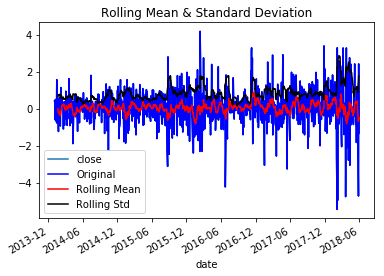

Results of Dickey-Fuller Test:
Test Statistic                  -15.924
p-value                           0.000
#Lags Used                        4.000
Number of Observations Used    1105.000
Critical Value (1%)              -3.436
Critical Value (5%)              -2.864
Critical Value (10%)             -2.568
dtype: float64


In [23]:
# differencing using lag1
diff=price-price.shift()
diff.dropna(inplace=True)
diff.plot()
test_stationarity(diff)

Taking first order differencing makes this time series stationary as indicated by the test statistic of -15.924 and a significant p-value. Removing stationarity from a time series by differencing is often a good thing to do before getting into modeling, however some models intrinsically handle differencing.

## ARIMA Modeling
An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of `ARIMA(p,d,q)` where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:
- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **q**: The size of the moving average window, also called the order of moving average.

Two diagnostic plots can be used to help choose the p and q parameters of the ARMA or ARIMA. They are:
- **Autocorrelation Function (ACF)**: The plot summarizes the correlation of an observation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.
- **Partial Autocorrelation Function (PACF)**: The plot summarizes the correlations for an observation with lag values that is not accounted for by prior lagged observations.
Both plots are drawn as bar charts showing the 95% and 99% confidence intervals as horizontal lines. Bars that cross these confidence intervals are therefore more significant and worth noting. 

Some useful patterns to observe in these plots are:
- The model is AR if the ACF trails off after a lag and has a hard cut-off in the PACF after a lag. This lag is taken as the value for p.
- The model is MA if the PACF trails off after a lag and has a hard cut-off in the ACF after the lag. This lag value is taken as the value for q.
- The model is a mix of AR and MA if both trail off.

## ACF

Text(0.5,1,'Autocorrelation Function')

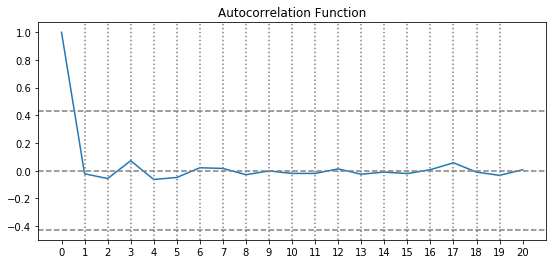

In [27]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
acf_price_plot = acf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_price_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_price_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_price_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

## PACF

Text(0.5,1,'Partial Autocorrelation Function')

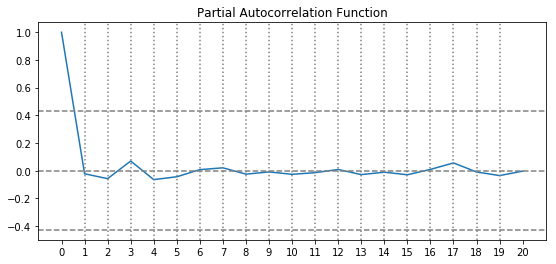

In [28]:
pacf_price_plot = pacf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_price_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_price_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_price_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

Following observations can be made by looking at the ACF and PACF plots. 
- Since both ACF and PACF plots trail off to zero, the model is both Auto Regressive and Moving Average.
- Since Lag-1 autocorrelation is zero or negative, and the autocorrelations are all small and patternless, it means that the series does not need a higher order of differencing.  
- A mixed AR-MA model seems to fit the data. 

## Fit ARIMA model
Looking at the ACF and PACF plots, an initial model could be with p=1, d=0 and q=0. 

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1110
Model:                     ARMA(1, 0)   Log Likelihood               -1505.251
Method:                       css-mle   S.D. of innovations              0.939
Date:                Mon, 04 Jun 2018   AIC                           3016.502
Time:                        22:59:12   BIC                           3031.539
Sample:                    01-03-2014   HQIC                          3022.188
                         - 05-31-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0494      0.028      1.791      0.074      -0.005       0.103
ar.L1.close    -0.0221      0.030     -0.736      0.462      -0.081       0.037
                                    Roots       

/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, 

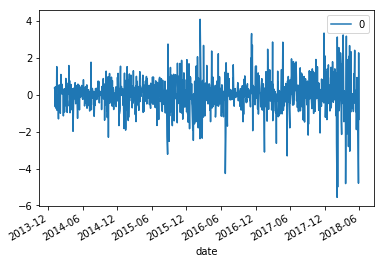

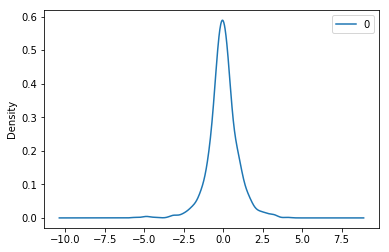

                 0
count  1110.000000
mean      0.000007
std       0.939501
min      -5.559812
25%      -0.430421
50%      -0.007466
75%       0.431994
max       4.080802


In [33]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(diff, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

The residual plots look to be white noise and moreover the errors seem to be normally distributed with a mean close to zero. Choosing the best p, d and q value can be automated by using a simple Grid Search technique.

## Grid Search
The ARIMA model for time series analysis and forecasting can be tricky to configure. There are 3 parameters that require estimation by iterative trial and error from reviewing diagnostic plots. We can automate the process of evaluating a large number of hyperparameters for the ARIMA model by using a grid search procedure. 

Diagnostic plots of the time series can be used along with heuristic rules to determine the hyperparameters of the ARIMA model. These are good in most, but perhaps not all, situations. We can automate the process of training and evaluating ARIMA models on different combinations of model hyperparameters. In machine learning this is called a grid search or model tuning.

31.294584556691152


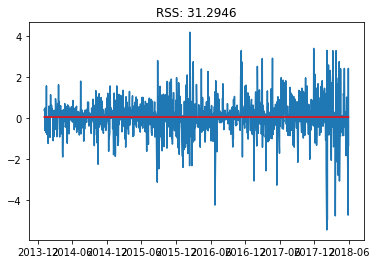

0 0 0
31.28599490175183


/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, 

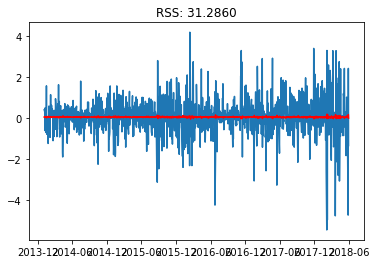

0 0 1
31.232641697830996


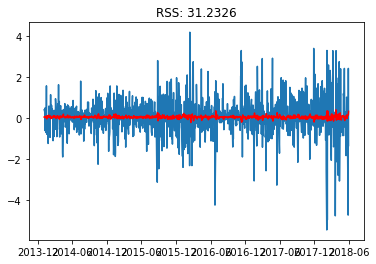

0 0 2


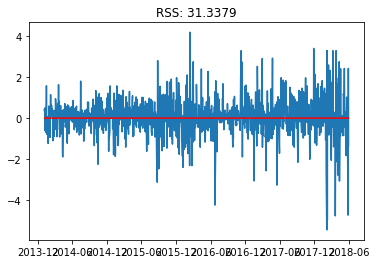

0 1 0


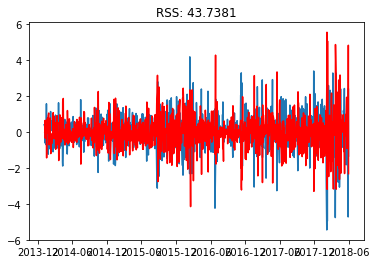

0 1 1


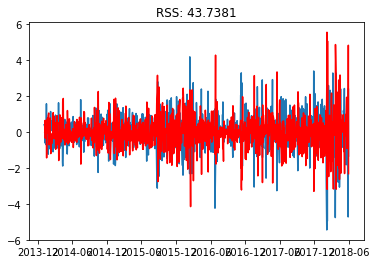

0 1 2


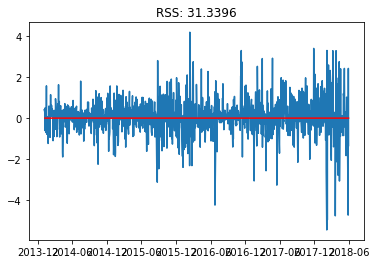

0 2 0


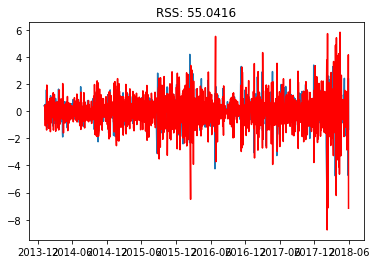

0 2 1


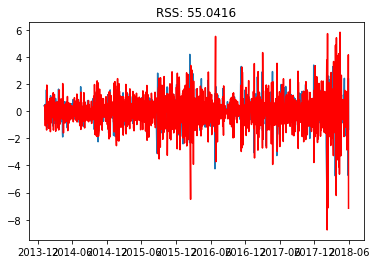

0 2 2


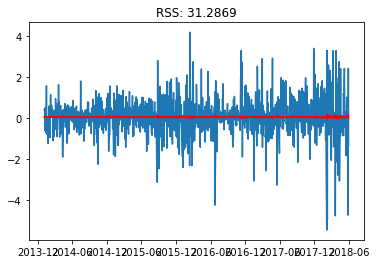

1 0 0


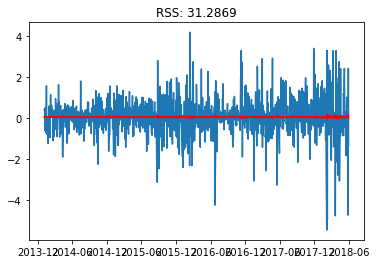

1 0 1


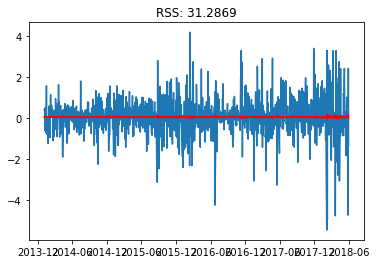

1 0 2


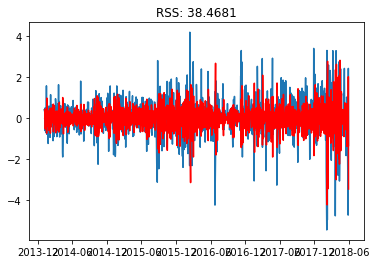

1 1 0


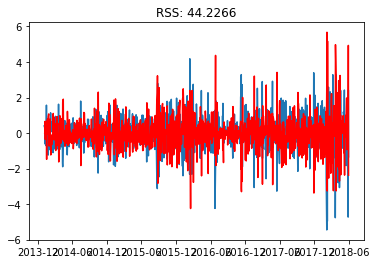

1 1 1


/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


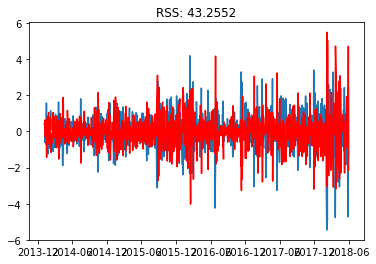

1 1 2


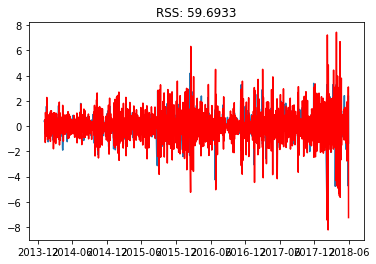

1 2 0


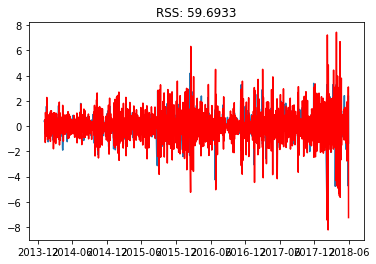

1 2 1


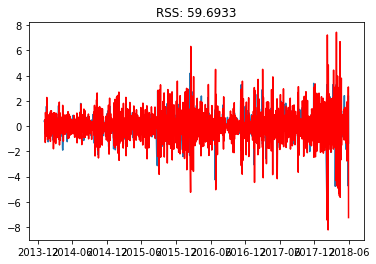

1 2 2


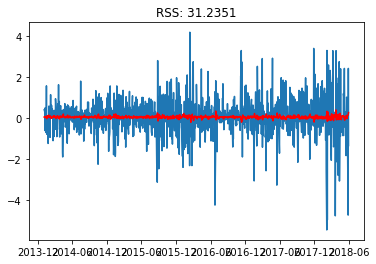

2 0 0
31.149596275393364


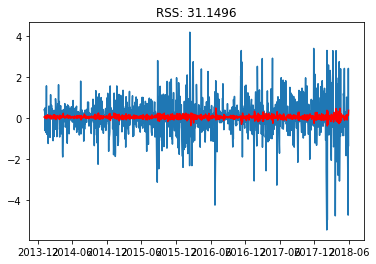

2 0 1


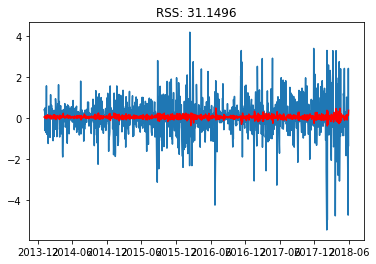

2 0 2


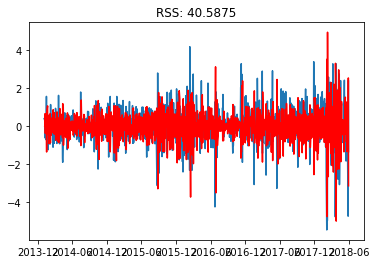

2 1 0


/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


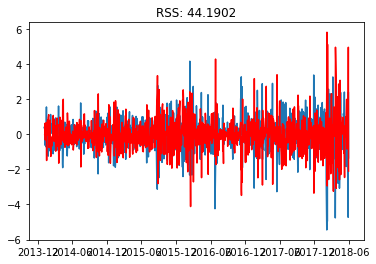

2 1 1


/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


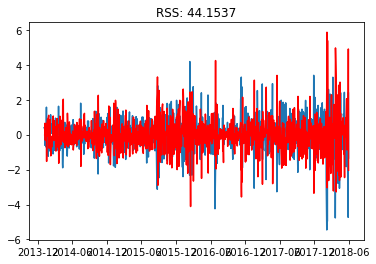

2 1 2


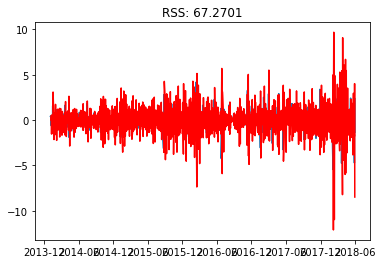

2 2 0


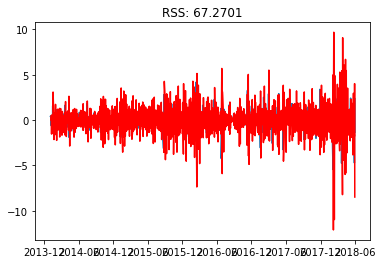

2 2 1


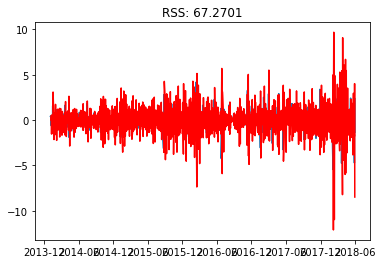

2 2 2


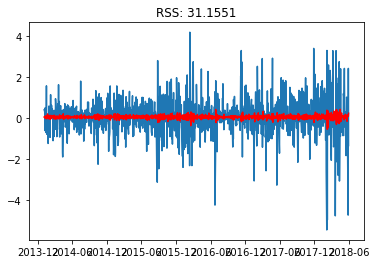

3 0 0
31.124364375136143


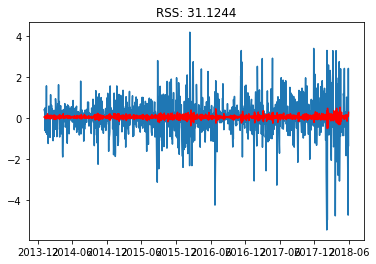

3 0 1
31.09543778593628


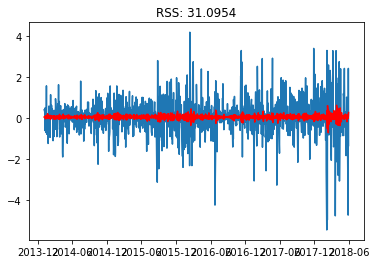

3 0 2


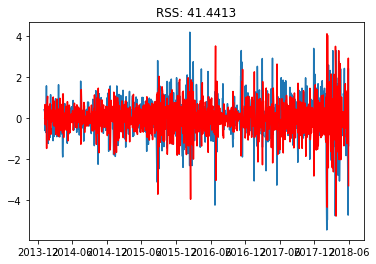

3 1 0


/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


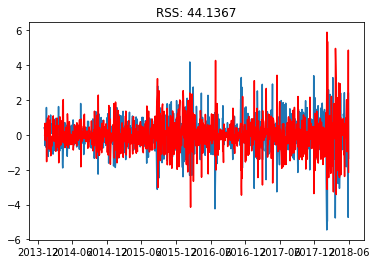

3 1 1


/Users/Shravan/anaconda3/envs/casestudy1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


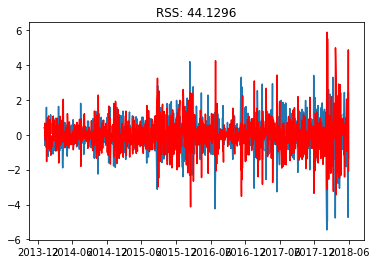

3 1 2


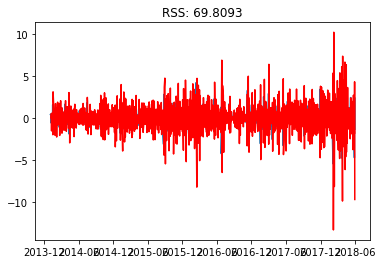

3 2 0


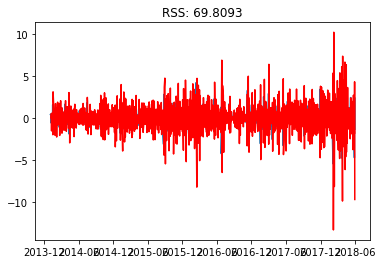

3 2 1


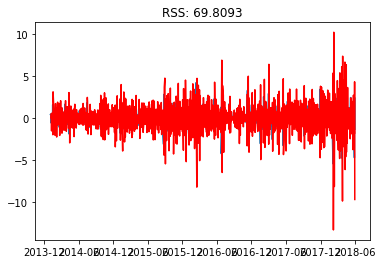

3 2 2


In [17]:
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [18]:
loss_best

31.09543778593628

In [19]:
best_ints

[3, 0, 2]

## Interpreting the result
Using ARIMA(3, 0, 2) yielded the best (lowest) RMSE value of 31.1496. This means that, using a Auto Regressive model with lag 3 and Moving Average window of size 2 with lag 1 differencing results in the lowest RMSE value of 31.14. At this point, the researcher can save this model and use it to forecast JPMorgan Chase's stock price at the next time step.

## Conclusion
The goal of time series forecasting is to make accurate predictions about the future. Robust time series models can be built by identifying and addressing the systematic components of a time series - like trends and seasonality. Ensuring that a time series is stationary reduces the complexity of the model and helps build models that focus more on the underlying structure of the data. Furthermore, finding the best parameters that minimize the cost function improves the reliability of time series forecasting. 

## References
- Book: "Introduction to Time Series Forecasting with Python" by Jason Brownlee
- Link: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#iex